In [207]:
import numpy as np
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math

In [208]:
def read_images(image_path):
    # img = cv2.imread(image_path)
    # rescaled_image  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(float)/255
    img = Image.open(image_path).convert('L')
    img = np.array(img).astype(float) / 255.0
    return img

### Scale Space by increasing Sigma

In [614]:

def check_for_odd_sigma(sigma):
    return sigma

def  generate_scale_space(image, initial_sigma, constant_multiplier, iterations):
    current_sigma = initial_sigma
    height = image.shape[0]
    width = image.shape[1]
    scale_space = np.empty((height, width, iterations))
    sigma_values = []
    for i in range(0, iterations):
        print(current_sigma)
        sigma_values.append(current_sigma)
        LoG_response = ndimage.gaussian_laplace(image, current_sigma,mode="nearest")
        sigma_normalized_LoG =  np.square(current_sigma) * LoG_response
        scale_space[:,:,i] = np.square(sigma_normalized_LoG)
        current_sigma = check_for_odd_sigma(math.ceil(constant_multiplier * current_sigma))

    return scale_space, sigma_values

In [615]:
def supress_function(image_window):
    middle_index = math.floor(image_window.shape[0]/2)
    return image_window[middle_index] if image_window[middle_index] == np.max(image_window) else 0

def non_maximum_suppression(scale_space, window_size):
    suppressed_space = np.empty((scale_space.shape[0],scale_space.shape[1],scale_space.shape[2]))

    for i in range(scale_space.shape[2]):
        suppressed_space[:,:,i] = ndimage.generic_filter(scale_space[:,:,i],function=supress_function, footprint=np.ones((window_size,window_size)))
    return suppressed_space

In [616]:
def find_optimal_scale(scale_space):
    return np.argmax(scale_space, axis=2), np.amax(scale_space, axis=2)

In [697]:
constant_scale_factor = 1.25
initial_sigma = 3
image_path = 'butterfly.jpg'
img = read_images(image_path)
scale_space, sigma_values = generate_scale_space(img , initial_sigma, constant_scale_factor, 10 )

3
4
5
7
9
12
15
19
24
30


In [698]:
img

array([[0.29411765, 0.29803922, 0.27843137, ..., 0.61568627, 0.60392157,
        0.61568627],
       [0.28627451, 0.27058824, 0.27058824, ..., 0.6       , 0.61176471,
        0.62352941],
       [0.31372549, 0.29411765, 0.25098039, ..., 0.58823529, 0.61568627,
        0.62745098],
       ...,
       [0.36862745, 0.36862745, 0.37647059, ..., 0.80392157, 0.78823529,
        0.73333333],
       [0.36078431, 0.36470588, 0.36862745, ..., 0.8       , 0.79215686,
        0.74509804],
       [0.38431373, 0.38823529, 0.38431373, ..., 0.80784314, 0.80392157,
        0.76470588]])

In [706]:
suppress_window = 3
suppressed_responses = non_maximum_suppression(scale_space, suppress_window)
maximum_sigma_by_axis, maximum_response_prev = find_optimal_scale(suppressed_responses)

In [767]:
maximum_response = ndimage.generic_filter(maximum_response_prev, function=supress_function, footprint=np.ones((11,11)))

In [768]:
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

In [769]:
rows, cols = np.nonzero(maximum_response)

In [770]:
sigmas = []
r = []
c = []
for i in range(len(rows)):
    exponent = maximum_sigma_by_axis[rows[i]][cols[i]]
    if maximum_response[rows[i]][cols[i]] >= 0.00999:
        sigmas.append( check_for_odd_sigma(math.ceil(pow(constant_scale_factor,exponent) * initial_sigma)) )
        r.append(rows[i])
        c.append(cols[i])

In [771]:
len(r)

714

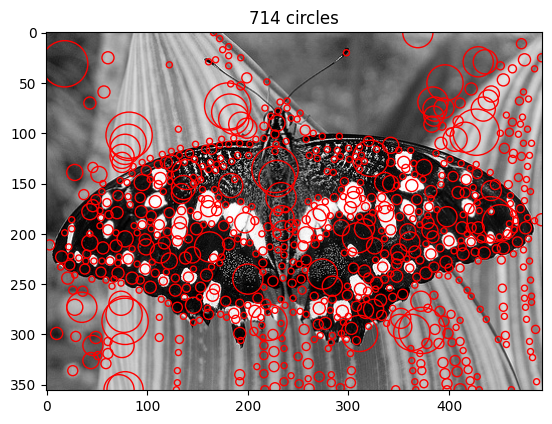

In [772]:
show_all_circles(read_images(image_path), c, r, sigmas)